O objetivo aqui é tentar rodar o LASSO

In [1]:
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.linear_model import LassoCV
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import utils

In [2]:
df = pd.read_csv("dados/dados_transformados.csv", sep=";", decimal=",", thousands=".")
df = utils.index_to_period(df)
df.head()

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,2481.49,0.4,49.609174,-2.34359,8.9,14.696341,348.7366,7.70,18.70,15.10
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,29.00,0.3,121.394093,1.00000,-0.8,15.073171,0.0000,10.11,14.74,24.27
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,2375.73,0.2,-166.416169,-5.00000,-10.1,16.078049,-10382.5684,4.04,2.71,10.95
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,-1911.68,0.2,21.276658,-4.00000,-5.3,16.454878,-339.4192,-0.45,6.35,-11.13
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,1488.90,0.2,14.892162,17.00000,16.2,15.324390,238.2590,-5.31,-15.02,8.03


In [4]:
# Normaliza dados
scaler = StandardScaler()
normalized_df = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_df)
normalized_df.index = df.index
normalized_df.columns = df.columns
normalized_df.head()

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.888700,0.646061,-1.439646,-0.913960,-0.480973,-0.285827,-0.341305,-0.170365,-0.655551,-0.097193,...,0.111028,0.600042,0.652383,-0.052337,1.687024,1.654331,-0.023559,0.508930,1.123911,0.281854
2004-02,0.435360,1.312838,0.045303,-0.030459,0.232655,0.016213,-0.052490,-0.107584,0.559792,0.825071,...,0.024474,0.478495,1.603535,0.018790,-0.166848,1.804537,-0.097617,0.695276,0.869326,0.495631
2004-03,0.012242,-0.202565,-0.260422,-0.246236,-0.031996,0.000956,-0.092518,-0.002344,-0.266162,-1.176894,...,0.107295,0.356948,-2.209958,-0.108846,-1.944270,2.205086,-2.302461,0.225931,0.095929,0.185106
2004-04,-0.289985,-0.778419,-0.686981,-0.104793,-0.012695,-0.077844,-0.065013,-0.638203,-0.063871,-0.633465,...,-0.044017,0.356948,0.276977,-0.087573,-1.026891,2.355292,-0.169696,-0.121246,0.329941,-0.329637
2004-05,0.133133,0.221748,-0.270613,-0.057072,0.273927,0.416999,0.204468,-0.100216,1.486492,1.949499,...,0.075997,0.356948,0.192382,0.359152,3.082205,1.904674,-0.047020,-0.497031,-1.043916,0.117033


In [5]:
y = normalized_df['ipca']
X = normalized_df.drop(columns=['ipca'])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=79)

In [6]:
regressor = LassoCV()
fh = ForecastingHorizon(1, is_relative=True)
forecaster = make_reduction(regressor)
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
eval_df = evaluate(
    forecaster=forecaster,
    cv=cv,
    y=y,
    X=X,
    strategy="refit",
    return_data=True
)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.039e-03, tolerance: 8.957e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.159e-03, tolerance: 8.957e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [7]:
y_pred = utils.extract_y_pred(eval_df)
y_pred.head()

e:\tcc\utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series([value[0] for _, value in df['y_pred'].items()])
e:\tcc\utils.py:82: FutureWarning: The 'freq' keyword in the PeriodArray constructor is deprecated and will be removed in a future version. Pass 'dtype' instead
  period_array = pd.arrays.PeriodArray(period_list, freq="M")


2017-03   -0.158702
2017-04   -0.121488
2017-05   -1.034587
2017-06   -0.808912
2017-07   -1.278948
Freq: M, dtype: float64

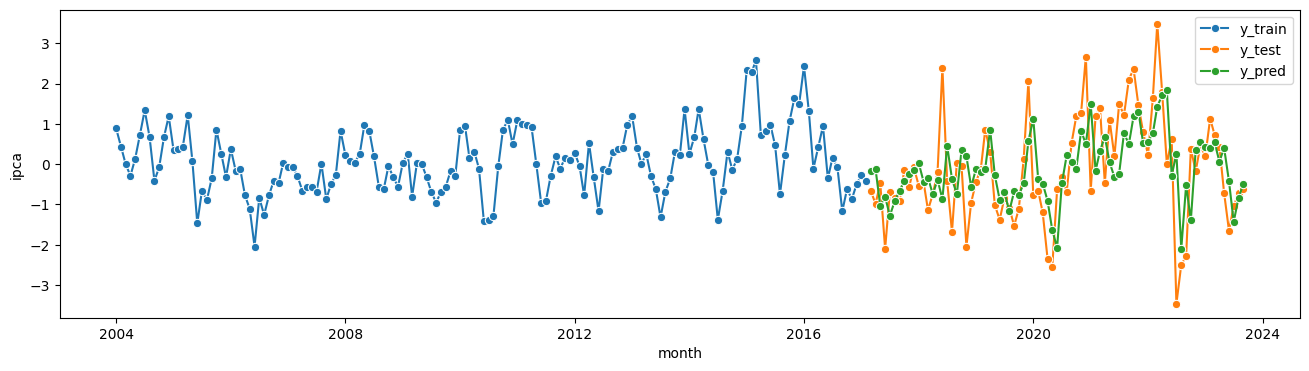

In [8]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = utils.plot_series(y_train, y_test, y_pred, labels=labels)

In [ ]:
y_train.head()

In [17]:
mape = MeanAbsolutePercentageError()
mape(y_test, y_pred)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


3.1685542327425655

Agora experimento normalizar apenas as variáveis independentes

In [19]:
df = pd.read_csv("dados/dados_transformados.csv", sep=";", decimal=",", thousands=".")
df = utils.index_to_period(df)
y = df['ipca']
X = df.drop(columns=['ipca'])
# Normaliza variáveis independentes
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)
normalized_X = pd.DataFrame(normalized_X, columns=X.columns, index=X.index)
normalized_X

,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,ind_varejo,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.646061,-1.439646,-0.913960,-0.480973,-0.285827,-0.341305,-0.170365,-0.655551,-0.097193,-1.049846,...,0.111028,0.600042,0.652383,-0.052337,1.687024,1.654331,-0.023559,0.508930,1.123911,0.281854
2004-02,1.312838,0.045303,-0.030459,0.232655,0.016213,-0.052490,-0.107584,0.559792,0.825071,-0.155501,...,0.024474,0.478495,1.603535,0.018790,-0.166848,1.804537,-0.097617,0.695276,0.869326,0.495631
2004-03,-0.202565,-0.260422,-0.246236,-0.031996,0.000956,-0.092518,-0.002344,-0.266162,-1.176894,0.169159,...,0.107295,0.356948,-2.209958,-0.108846,-1.944270,2.205086,-2.302461,0.225931,0.095929,0.185106
2004-04,-0.778419,-0.686981,-0.104793,-0.012695,-0.077844,-0.065013,-0.638203,-0.063871,-0.633465,-0.026862,...,-0.044017,0.356948,0.276977,-0.087573,-1.026891,2.355292,-0.169696,-0.121246,0.329941,-0.329637
2004-05,0.221748,-0.270613,-0.057072,0.273927,0.416999,0.204468,-0.100216,1.486492,1.949499,0.107902,...,0.075997,0.356948,0.192382,0.359152,3.082205,1.904674,-0.047020,-0.497031,-1.043916,0.117033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.130823,0.045303,-1.714049,0.788114,-0.947301,-1.039144,0.762749,-0.362909,-0.265812,0.200379,...,-0.582858,0.721589,-0.882456,0.848423,-0.568201,-0.895281,0.042116,-0.550384,0.214221,-1.701585
2023-06,-1.293656,0.045303,0.559290,0.754431,2.792116,1.966304,2.035326,-1.116902,-0.346320,-0.364033,...,-2.210303,1.086230,0.411899,-0.555571,0.578523,-1.014863,0.442415,0.406865,0.634028,0.062482
2023-07,-1.627044,0.045303,1.789027,-0.489665,-0.873332,-0.687946,0.752422,-0.474049,0.248544,0.389150,...,-1.961727,1.450871,-0.476275,-0.981023,-0.166848,-1.054723,0.418206,1.152250,1.442142,0.590979


In [20]:
regressor = LassoCV()
fh = ForecastingHorizon(1, is_relative=True)
forecaster = make_reduction(regressor)
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
eval_df = evaluate(
    forecaster=forecaster,
    cv=cv,
    y=y,
    X=normalized_X,
    strategy="refit",
    return_data=True
)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.863e-04, tolerance: 9.604e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e-03, tolerance: 9.604e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [21]:
y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])
y_pred.index = y_test.index
y_pred

C:\Users\asfra\AppData\Local\Temp\ipykernel_11112\2757861609.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])


2017-03    0.518247
2017-04    0.402765
2017-05    0.261441
2017-06    0.164787
2017-07    0.204338
             ...   
2023-05    0.503581
2023-06    0.448383
2023-07   -0.000503
2023-08    0.102043
2023-09    0.309904
Freq: M, Length: 79, dtype: float64

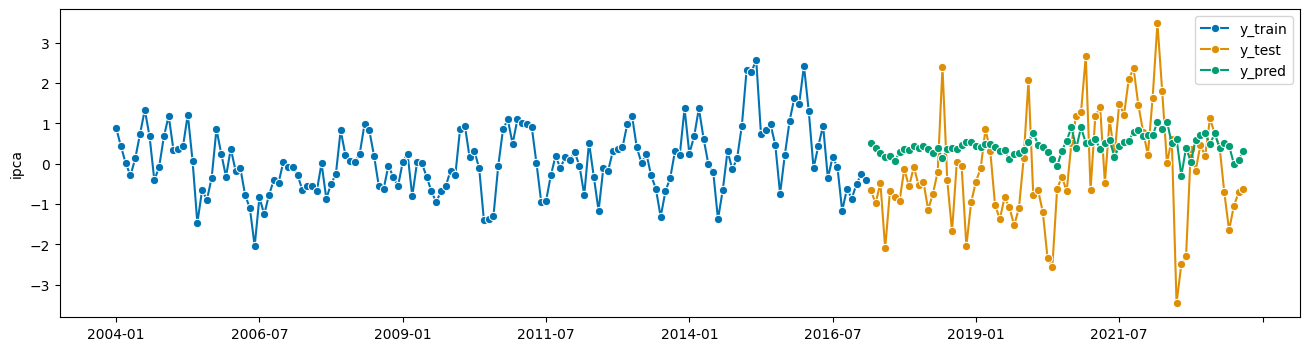

In [22]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(y_train, y_test, y_pred, labels=labels)

In [23]:
mape = MeanAbsolutePercentageError()
mape(y_test, y_pred)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


2.5928097419640754

In [15]:
lag_df = pd.read_csv("dados/lags_transformados.csv", sep=";", decimal=",", thousands=".")
lag_df = utils.index_to_period(lag_df)
lag_df

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,crb_metal_1,crb_metal_2,crb_metal_3,crb_metal_4,crb_metal_5,crb_metal_6,crb_metal_7,crb_metal_8,crb_metal_9,crb_metal_10
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59,-3.76
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,-11.13,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.23,0.51,0.000000,-23521679.0,37144204.0,-60304921.0,-53107060.0,3903.44,-0.0369,-0.740,...,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32,-28.60
2023-06,-0.08,0.04,0.000000,10468536.0,35565946.0,178689253.0,102168255.0,9751.93,-0.1312,-0.920,...,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32
2023-07,0.12,-0.07,0.000000,28855151.0,-22727138.0,-55577408.0,-34962544.0,3855.98,-0.0508,0.410,...,5.69,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46


In [16]:
y = lag_df['ipca']
X = lag_df.drop(columns=['ipca'])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=79)

In [17]:
regressor = LassoCV()
fh = ForecastingHorizon(1, is_relative=True)
forecaster = make_reduction(regressor)

In [18]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
eval_df = evaluate(
    forecaster=forecaster,
    cv=cv,
    y=y,
    X=X,
    strategy="refit",
    return_data=True
)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e-03, tolerance: 9.541e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-03, tolerance: 9.541e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [19]:
y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])
y_pred.index = y_test.index
y_pred

C:\Users\asfra\AppData\Local\Temp\ipykernel_7452\2757861609.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])


month
2017-03    0.481959
2017-04    0.480403
2017-05    0.478133
2017-06    0.477020
2017-07    0.472368
             ...   
2023-05    0.467883
2023-06    0.466816
2023-07    0.464375
2023-08    0.462844
2023-09    0.461814
Freq: M, Length: 79, dtype: float64

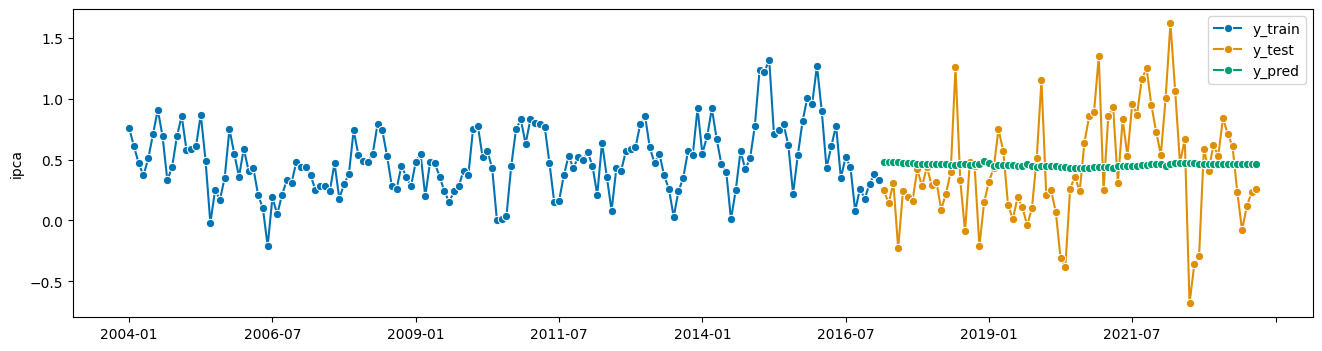

In [20]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(y_train, y_test, y_pred, labels=labels)